In [44]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [45]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


In [46]:
df = pd.read_csv("krushing_kingdoms.csv")
df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention
0,250642234,level_5,21,True,False
1,330729049,level_5,1,False,False
2,955307973,level_7,76,True,True
3,908651903,level_7,76,True,False
4,983320188,level_5,1,False,False


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 50000 non-null  int64 
 1   team_level_access  50000 non-null  object
 2   minutes_played     50000 non-null  int64 
 3   day1_retention     50000 non-null  bool  
 4   day7_retention     50000 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.2+ MB


# Define Hypothesis

**Null Hypothesis:** There is no difference in retention between the two groups

**Alternative Hypothesis:** There is a difference in the mean retention between the 2 groups

# EDA

In [48]:
df.describe()

,id,minutes_played
count,5.000000e+04,50000.000000
mean,5.000967e+08,25.884040
std,2.894632e+08,51.130086
min,7.746000e+03,0.000000
25%,2.502251e+08,3.000000
50%,5.008450e+08,8.000000
75%,7.500803e+08,26.000000
max,9.999952e+08,1481.000000


The dataset contains outliers, which can skew results and impact the accuracy of statistical analyses and model performance. Cleaning outliers helps ensure more reliable insights and robust model predictions by focusing on the typical patterns within the data.

In [49]:
# 2. Group Comparisons
# Aggregates 'minutes_played' by calculating mean and median, and 'day1_retention'
# and 'day7_retention' by calculating mean for each 'team_level_access' group
grouped = df.groupby('team_level_access').agg({'minutes_played': ['mean', 'median'],
                                               'day1_retention': 'mean',
                                               'day7_retention': 'mean'})
grouped.head()


minutes_played        day1_retention day7_retention
                            mean median           mean           mean
team_level_access                                                    
level_5                26.038934    9.0       0.448304       0.189176
level_7                25.732092    8.0       0.441561       0.181537

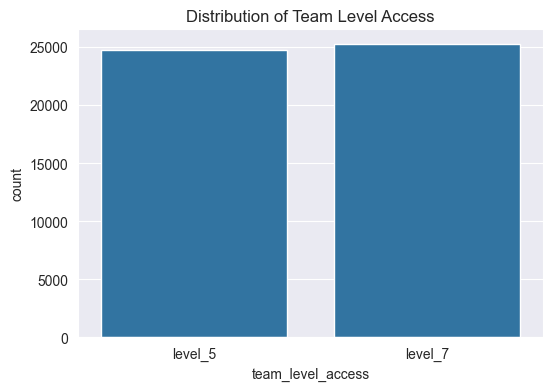

In [50]:
plt.figure(figsize=(6, 4))
sns.countplot(x='team_level_access', data=df)
plt.title('Distribution of Team Level Access')
plt.show()

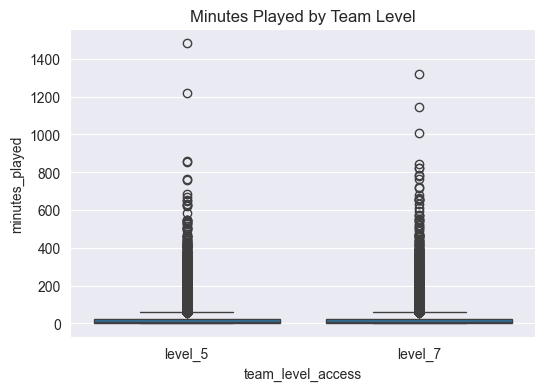

In [51]:
# Boxplot of minutes played by team level
# Visualizes the distribution and outliers of 'minutes_played' across different 'team_level_access' categories
plt.figure(figsize=(6, 4))
sns.boxplot(x='team_level_access', y='minutes_played', data=df)
plt.title('Minutes Played by Team Level')
plt.show()

/var/folders/sg/1vlr_mz12nj80bfjc09d_f940000gn/T/ipykernel_55066/855252537.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cohort_data = df.pivot_table(index='team_level_access',


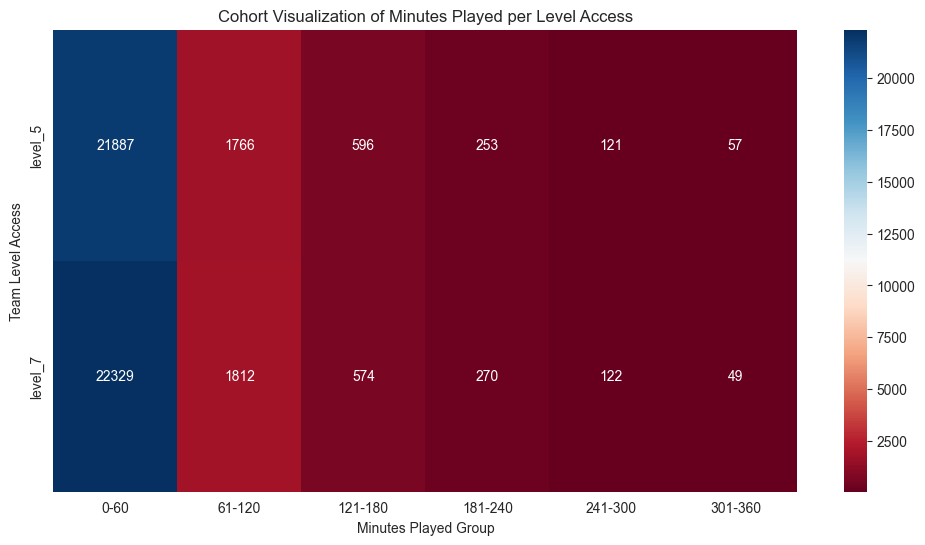

In [52]:
# Binning the minutes played into categories
# This divides 'minutes_played' into specified ranges to simplify analysis
bins = [0, 60, 120, 180, 240, 300, 360]
labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-360']
df['minutes_played_group'] = pd.cut(df['minutes_played'],
                                    bins=bins, labels=labels, right=False)

# Creating a pivot table to summarize the count of 'minutes_played_group' by 'team_level_access'
cohort_data = df.pivot_table(index='team_level_access',
                             columns='minutes_played_group',
                             aggfunc='size', fill_value=0)

# Plotting the cohort data as a heatmap
# This visualizes the distribution of 'minutes_played_group' across 'team_level_access'
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_data, annot=True, fmt="d", cmap="RdBu")

# Add title and label
plt.title('Cohort Visualization of Minutes Played per Level Access')
plt.xlabel('Minutes Played Group')
plt.ylabel('Team Level Access')
plt.show()

# Outliers

<Axes: >

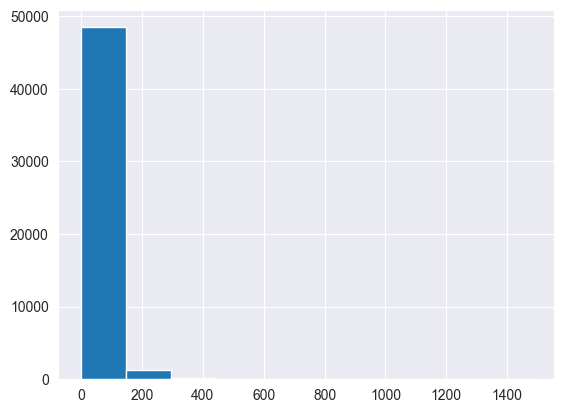

In [53]:
df.minutes_played.hist()

In [54]:
df.describe()

,id,minutes_played
count,5.000000e+04,50000.000000
mean,5.000967e+08,25.884040
std,2.894632e+08,51.130086
min,7.746000e+03,0.000000
25%,2.502251e+08,3.000000
50%,5.008450e+08,8.000000
75%,7.500803e+08,26.000000
max,9.999952e+08,1481.000000


In [55]:
# Calculating Interquartile Range (IQR) for 'minutes_played'
# This helps in identifying the range within which the central 50% of the data lies, useful for outlier detection
Q1 = df['minutes_played'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['minutes_played'].quantile(0.75)  # Third quartile (75th percentile)

IQR = Q3 - Q1  # Interquartile Range

In [56]:
# Defining outliers for 'minutes_played' based on the IQR method
# Outliers are data points that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((df['minutes_played'] < (Q1 - 1.5 * IQR)) | (df['minutes_played'] > (Q3 + 1.5 * IQR)))

# Removing outliers from the dataset
df_cleaned = df[~outliers]

# Display summary statistics for the cleaned dataset
# This provides an overview of the data distribution after removing outliers
df_cleaned.describe()

,id,minutes_played
count,4.431900e+04,44319.000000
mean,4.993766e+08,12.208240
std,2.893929e+08,13.750095
min,7.746000e+03,0.000000
25%,2.491266e+08,2.000000
50%,5.000784e+08,7.000000
75%,7.496319e+08,17.000000
max,9.999952e+08,60.000000


# Randomization

In [57]:
# Randomly assign users to two groups
# '1' represents group A and '0' represents group B
# number_of_users specifies the total number of users
# np.random.choice is used to randomly assign each user to one of the two groups with equal probability
number_of_users = 500
group_assignment = np.random.choice([0, 1],
                                    size=number_of_users, p=[0.5, 0.5])

# Count the number of users in each group
np.unique(group_assignment, return_counts=True)

(array([0, 1]), array([231, 269]))

### Block Randomization

In [58]:
from sklearn.utils import shuffle

# 'block_size' defines the number of users per block
# Each block contains an equal number of users for each group (0 and 1)
block_size = 50

# Create blocks with an equal number of users for each group (0 and 1)
blocks = [0] * block_size + [1] * block_size

# Shuffle the blocks and repeat to cover the total number of users
# Ensure that users are evenly distributed within blocks
group_assignment = shuffle(blocks * int(number_of_users / (2 * block_size)))

# Count the number of users in each group after block randomization
np.unique(group_assignment, return_counts=True)

(array([0, 1]), array([250, 250]))

### Stratified Randomization

Ensuring balanced representation across different age groups

In [59]:
# Create a copy of our df
df_stratified = df.copy()

In [60]:
# Define age groups for stratification
age_groups = ['18-25', '26-34', '36-45', '46-55']

# Create a new variable 'age_group' to randomly assign users to one of the defined age groups
# This ensures that the randomization takes age distribution into account
df_stratified['age_group'] = np.random.choice(age_groups,
                                              size=len(df_stratified),
                                              replace=True)
# Preview
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,age_group
0,250642234,level_5,21,True,False,0-60,26-34
1,330729049,level_5,1,False,False,0-60,36-45
2,955307973,level_7,76,True,True,61-120,36-45
3,908651903,level_7,76,True,False,61-120,26-34
4,983320188,level_5,1,False,False,0-60,46-55


In [61]:
# Build a function for stratified randomization
def stratified_randomization(group):
    # Assign 'A' or 'B' with equal probability
    group['group_assignment'] = np.random.choice(['A', 'B'],
                                              size = len(group),
                                              p = [0.5, 0.5])
    return group

In [62]:
# Apply the function
df_stratified = df_stratified.groupby(
    'age_group', group_keys = False).apply(stratified_randomization, include_groups=False)
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,group_assignment
0,250642234,level_5,21,True,False,0-60,A
1,330729049,level_5,1,False,False,0-60,A
2,955307973,level_7,76,True,True,61-120,A
3,908651903,level_7,76,True,False,61-120,A
4,983320188,level_5,1,False,False,0-60,B


In [26]:
# Check the results
df_stratified.groupby(['age_group', 'group_assignment']).size()

age_group  group_assignment
18-25      A                   6231
           B                   6305
26-34      A                   6224
           B                   6226
36-45      A                   6253
           B                   6241
46-55      A                   6244
           B                   6276
dtype: int64

### Cluster Randomization / Geotest

In [30]:
# Build a copy from our df
clustering_df = df.copy()

In [31]:
# Define the list of cities
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston']

# Create a new variable 'city' and randomly assign one of the cities to each data point
# This simulates data distribution across different cities
clustering_df['city'] = np.random.choice(cities,
                                         size=len(clustering_df),
                                         replace=True)
# Preview
clustering_df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city
0,250642234,level_5,21,True,False,0-60,Chicago
1,330729049,level_5,1,False,False,0-60,Chicago
2,955307973,level_7,76,True,True,61-120,Los Angeles
3,908651903,level_7,76,True,False,61-120,Houston
4,983320188,level_5,1,False,False,0-60,Chicago


In [32]:
# Create a list with two cities in one cluster (0) and two cities in another cluster (1)
assigned_clusters = [0, 0, 1, 1]

# Shuffle the list to randomly assign clusters
np.random.shuffle(assigned_clusters)

In [33]:
# Create a dictionary to map each city to a cluster group
city_to_group = dict(zip(cities, assigned_clusters))
city_to_group

{'New York': 0, 'Los Angeles': 1, 'Chicago': 1, 'Houston': 0}

In [34]:
# Create the cluster group variable in the dataframe
clustering_df['cluster_group'] = clustering_df['city'].map(city_to_group)
clustering_df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city,cluster_group
0,250642234,level_5,21,True,False,0-60,Chicago,1
1,330729049,level_5,1,False,False,0-60,Chicago,1
2,955307973,level_7,76,True,True,61-120,Los Angeles,1
3,908651903,level_7,76,True,False,61-120,Houston,0
4,983320188,level_5,1,False,False,0-60,Chicago,1


In [35]:
# Check the results
clustering_df.groupby(['city', 'cluster_group']).size()

city         cluster_group
Chicago      1                12559
Houston      0                12383
Los Angeles  1                12671
New York     0                12387
dtype: int64

# Sample Size Calculation

In [63]:
# Settings
alpha = 0.05  # Significance level
power = 0.8   # Power of the test
mde = 0.05    # Minimum Detectable Effect (the smallest effect size you're interested in detecting)

In [65]:
# Compute the baseline retention rate for 'level_5' access group
baseline_retention = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5']['day7_retention'].mean()

print(f"The Baseline Retention is {baseline_retention}")

The Baseline Retention is 0.11644772851669404


In [66]:
# Calculate the effect size based on the baseline retention and minimum detectable effect
effect_size = sm.stats.proportion_effectsize(baseline_retention,
                                             baseline_retention + mde)
effect_size

np.float64(-0.14400018988992425)

In [67]:
# Initiate the power analysis to determine the required sample size
power_analysis = sm.stats.NormalIndPower()

# Calculate the sample size needed for each group based on the effect size, power, and alpha
sample_size_discrete = power_analysis.solve_power(effect_size=effect_size,
                                                  power=power,
                                                  alpha=alpha,
                                                  ratio=1.0)

# Print the sample size needed per group
print(f"The Sample Size per group is {round(sample_size_discrete)}")


The Sample Size per group is 757


## Sample size for continuous outcomes

In [69]:
# Compute the baseline average of minutes played for users with 'level_5' access
baseline_minutes = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played'].mean()
print(f"The Baseline minutes is {baseline_minutes}")

# Compute the baseline variability (standard deviation) of minutes played for users with 'level_5' access
baseline_sigma = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played'].std()
print(f"The Baseline Variability is {baseline_sigma}")


The Baseline minutes is 12.262953840540048
The Baseline Variability is 13.6339887214411


In [70]:
# Compute the effect size using the minimum detectable effect (MDE), baseline mean, and standard deviation
effect_size = mde * baseline_minutes / baseline_sigma
print(f"The effect size is {effect_size}")

The effect size is 0.0449719964241098


In [71]:
# Calculate the Z-scores for the desired alpha and power
Zalpha = stats.norm.ppf(1-alpha / 2)  # Z-score for the two-tailed test at the specified alpha level
Zbeta = stats.norm.ppf(power)  # Z-score corresponding to the specified power level

In [72]:
# Calculate the required sample size per group for the continuous outcome measure
sample_size_continuous = (
    (Zalpha + Zbeta)**2 * (baseline_sigma**2)) / (effect_size **2)

print(f"The Sample Size per group is {sample_size_continuous:.0f}")

The Sample Size per group is 721388


# Post Analysis

## Post analysis for retention with calculated sample size

In [74]:
# Determine the sample size for each group based on the calculated sample size
N = int(sample_size_discrete)

# Randomly sample N users from 'level_5' team access group
sample5 = df_cleaned[
    df_cleaned['team_level_access'] == 'level_5'].sample(n=N,
                                                         random_state=1502)

# Randomly sample N users from 'level_7' team access group
sample7 = df_cleaned[
    df_cleaned['team_level_access'] == 'level_7'].sample(n=N,
                                                         random_state=1502)


In [75]:
# Calculate the number of trials (total users)
n_5 = sample5['day7_retention'].count()
n_7 = sample7['day7_retention'].count()

# Calculate the number of successes (retention count)
successes_5 = sample5['day7_retention'].sum()
successes_7 = sample7['day7_retention'].sum()

In [76]:
import statsmodels.stats.proportion as proportion

# Perform a two-sample z-test for proportions to compare the retention rates
# between 'level_5' and 'level_7'
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7], [n_5, n_7],
                                                alternative="two-sided")

# Interpret the p-value to determine if the difference in retention rates is statistically significant
interpret_p_value(p_value, threshold=0.05)

p-value (0.4107621742385773) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


### Post Analysis for Retention with the Complete Data

In [77]:
# Determine the sample size per group based on the previously computed sample size
N = int(sample_size_discrete)

# Sample data for 'level_5' team members. Note: Sample size N is not applied here; it selects the entire group.
sample5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']

# Sample data for 'level_7' team members. Note: Sample size N is not applied here; it selects the entire group.
sample7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']

In [78]:
# Calculate the number of trials (total users)
n_5 = sample5['day7_retention'].count()
n_7 = sample7['day7_retention'].count()

# Calculate the number of successes (retention count)
successes_5 = sample5['day7_retention'].sum()
successes_7 = sample7['day7_retention'].sum()

In [79]:
# Compute the retention rate by dividing the number of successes by the number of trials
rr_5 = successes_5 / n_5
rr_7 = successes_7 / n_7

print(f"The Retention Rate for level 5 is {rr_5}")
print(f"The Retention Rate for level 7 is {rr_7}")

The Retention Rate for level 5 is 0.11644772851669404
The Retention Rate for level 7 is 0.10877427997320831


In [80]:
# Proportions Test
import statsmodels.stats.proportion as proportion

# Perform a z-test for the equality of proportions between two groups
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7], [n_5, n_7],
                                                alternative="two-sided")

# Interpret the p-value to determine if there is a significant difference between the two proportions
interpret_p_value(p_value, threshold=0.05)

p-value (0.010607771169938515) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


### Post Analysis for Minutes Played

In [82]:
# Prepare the inputs
minutes5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played']

minutes7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']['minutes_played']

# Perform a two-sample t-test to compare the means of 'minutes_played' between two groups
t_statistic, p_value = stats.ttest_ind(minutes5,
                                       minutes7,
                                       alternative='two-sided')

# Interpret the p-value to determine if there is a significant difference in the means between the two groups
interpret_p_value(p_value, threshold=0.05)

p-value (0.4072031194931294) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.
